# Colocalization

Colocalization refers to two distinct measures: co-occurance and correlation [https://jcs.biologists.org/content/131/3/jcs211847].




## Co-occurance

In this context, we tried to evaluate the overlap of the set of pixels between two images. The set of pixels can be obtained by segmenting the orginal images. The segmentation step often allows to obtain regular objects, remove the background and the noise.

We start by creating a pair of test images. The images are composed of circles of which a fraction is overlapping.


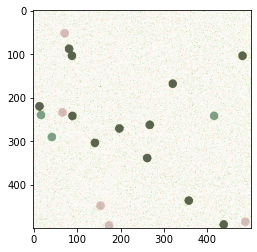

In [806]:
import numpy as np 
import matplotlib.pyplot as plt

def create_overlapping_circles(shape,m,r0,rho,noise=0.05):
    ''' Create a test image pair with random circles 
    Parameter
    ---------
    shape : image size
    m : total number of circle
    r0 : radius of circles
    rho : proportion of overlapping circle
    Result
    ------
    I1,I2 two images with overlapping circles
    '''
    np.random.seed()
    x,y = np.meshgrid(range(shape[1]), range(shape[0]))
    p = 0.01+0.98*np.random.rand(3,m)
    S = np.array([[shape[1],0,0],[0,shape[0],0],[0,0,0]])
    p = np.matmul(S,p)
    p[2,:] = p[2,:] + r0
    I1 = np.zeros(shape)
    I2 = np.zeros(shape)
    n1 = 0
    n2 = 0
    n12 = 0
    for i in range(m):
        v = np.random.rand()
        D = ((x - p[0,i]) / p[2,i])**2 + ((y-p[1,i]) / p[2,i])**2 < 1
        if v < 0.5 + rho/2 :
            I1 = np.logical_or(I1 , D)
            n1 = n1 + 1
        if  v > 0.5 - rho/2:
            I2 = np.logical_or(I2 , D)
            n2 = n2 + 1
        if  v < 0.5 + rho/2  and v > 0.5 - rho/2: 
            n12 = n12 + 1
    I1 = np.logical_or(I1 , np.random.random_sample(I1.shape) < noise)
    I2 = np.logical_or(I2 , np.random.random_sample(I2.shape) < noise)
    return I1,I2 
    
im1, im2 = create_overlapping_circles((500,500),20,10,0.5)

plt.imshow(im1,cmap='Reds',alpha=0.5)
plt.imshow(im2,cmap='Greens',alpha=0.5)

Let's define another way to visualize the image pair:

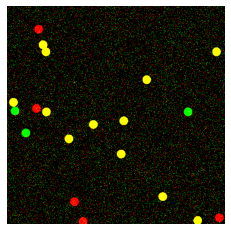

In [807]:
def to_rgb(im1,im2):
    ''' Convert the a2 channel image to a xyc rgb normlized image'''
    rgb = np.zeros((im1.shape[0], im1.shape[1], 3))
    rgb[:,:,0] = im1
    rgb[:,:,1] = im2
    if im1.dtype == 'float':
        a = min(np.min(im1), np.min(im2))
        b = max(np.max(im1), np.max(im2))
        return (rgb - a) / (b-a)
    else :
        return rgb

# Another way to display the image pair:
plt.imshow(to_rgb(im1,im2))
plt.axis('off')
plt.show()

### Manders coefficients

To evaluate co-occurance we compute the Manders coefficients defined by the ratios M1 = (A . B) / (A) and M2 = (A . B) / B. The regions A and B will be defined by segmenting each channels.

Manders, E., Verbeek, F. and Aten, J. (1993) Measurement of co‐localization of objects in dual‐colour confocal images. Journal of Microscopy, 169, Pt 3, 375–382. 

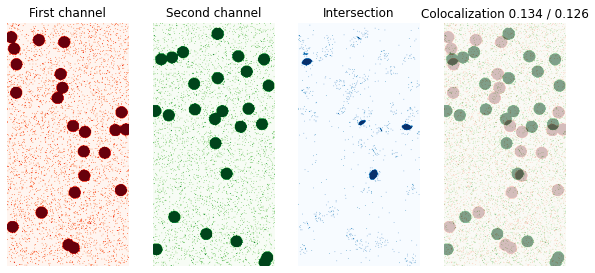

In [808]:
# Let's define a function for computing the Manders coefficients
def manders_coefficients(im1,im2,display=False):
    ''' Compute Manders overlap coefficients'''
    intersect = np.logical_and(im1,im2)
    p12 = np.sum(intersect>0)
    p1 = np.sum(im1>0)
    p2 = np.sum(im2>0)
    if display:
        fig, ax = plt.subplots(1, 4,figsize=(10,7))
        ax[0].imshow(im1,cmap='Reds')
        ax[0].set_title('First channel')
        ax[1].imshow(im2,cmap='Greens')
        ax[1].set_title('Second channel')
        ax[2].imshow(intersect,cmap='Blues')
        ax[2].set_title('Intersection')
        ax[3].imshow(im1,cmap='Reds',alpha=0.5)
        ax[3].imshow(im2,cmap='Greens',alpha=0.5)
        ax[3].set_title(f'Colocalization {p12/p1:.3f} / {p12/p2:.3f}')
        for a in ax:
            a.set_axis_off()
    return ( p12 / p1, p12 / p2)

im1,im2 = create_overlapping_circles((400,200),50,10,0.)
M1,M2 = manders_coefficients(im1,im2,True)


0.21646751029894845


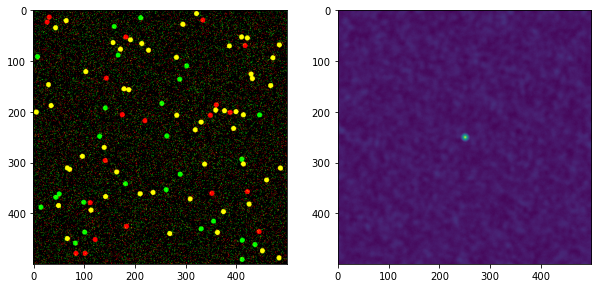

In [809]:
def normxcorr(template,image):
    '''
        Normalized cross correlation
    '''
    from math import sqrt
    template = template - np.mean(template)
    image = image - np.mean(image)
    F = np.fft.fftn(image)
    T = np.fft.fftn(template)
    out = np.real(np.fft.ifftn(F * np.conj(T)))
    F2 = np.fft.fftn(np.square(image))
    A1 = np.fft.fftn(np.ones(template.shape))
    image = np.real(np.fft.fftn(F2*A1)) - np.square(np.real(np.fft.fftn(F*A1)))/np.prod(template.shape)
    image[np.where(image < 0)] = 0
    template = np.sum(np.square(template))
    out = out / np.sqrt(image * template)
    out[np.where(np.logical_not(np.isfinite(out)))] = 0
    return np.fft.fftshift(out) * sqrt(np.prod(image.shape))

im1,im2 = create_overlapping_circles((500,500), 100, 5, .5)
#im1 = im1 + 0.1*np.random.random_sample(im1.shape)
#im2 = im2 + 0.1*np.random.random_sample(im2.shape)
#im2 = np.roll(im2,10)
C = normxcorr(im1,im2)
fig, ax = plt.subplots(1, 2,figsize=(10,7))
ax[0].imshow(to_rgb(im1,im2))
ax[1].imshow(C)
#ax[1].addcolorbar()
print(np.max(C))



## GcoPS

Two binary images can be seen as two random sets for which we would like to test the independance from a probabilitic point of view.
This idea, proposed in  https://onlinelibrary.wiley.com/doi/full/10.1111/biom.13115, is to test the independance of the probability of belonging to each set $p_1$ and $p_2$ and to belong to both sets $p_{12}$ by looking at the value of $D=p_{12}- p_1p_2$ normalized by the autocorrelation $C_1$ and $C_2$ of the two set:
$$T  = \sqrt{|R|} \frac{p_{12} - p_1 p_2}{\sqrt{\sum_R C_1 C_2}} $$

The $T$ statistic is assumed to be normally distributed which allow to compute a p-value. We can interpret this p-value as if the set are colocalized it is due to an actual overlap and not randomness. 




-0.031011930158869785
0.14919374843128025
-0.023306249999999994
0.14919375


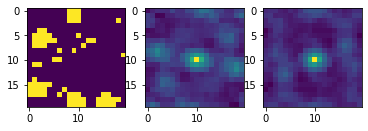

In [810]:
def autocorrelation(im):
    im = im - np.mean(im)
    shp = (im.shape[0],im.shape[1])
    C = np.zeros(shp)
    N = np.zeros(shp)
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            for k in range(im.shape[0]):
                for l in range(im.shape[1]):
                        h1 = k-i+im.shape[0]//2
                        h2 = l-j+im.shape[0]//2
                        if h1 >=0 and h2 >= 0 and h1 < shp[0] and h2 < shp[1]:
                            C[h1,h2] += (im[i,j] * im[k,l])
                            N[h1,h2] += 1
    I = np.where(N>0)
    C[I] = C[I] / N[I]
    return C

def autocorrelation_fft(im):
     im = im - np.mean(im)
     n = np.prod(im.shape)
     return  np.real(np.fft.ifftn(np.square(np.abs(np.fft.fftn(im))))) / n

im1,im2 = create_overlapping_circles((20,20),10,2, 0.5)
C1 = variogram(im1.astype('f'))
C2 = np.fft.fftshift(autocorrelation_fft(im1))
fig,ax = plt.subplots(1,3)
ax[0].imshow(im1)
ax[1].imshow(C1)
ax[2].imshow(C2)
print(np.min(C1))
print(np.max(C1))
print(np.min(C2))
print(np.max(C2))

Manders M1:0.224, M2:0.269
GCoPS D:0.015, T:5.518, pvalue:3.427e-08 The two sets are not independant


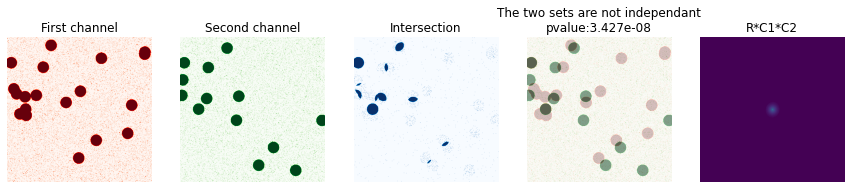

In [1049]:
def GcoPS(im1,im2,alpha=0.05,twosided=False,display=False):
    ''' Test the colocalization of two random sets

    Parameter
    ---------
    im1 : numpy array
    im2 : numpy array
    alpha : level of confidence for the pvalue
    display: display results in a figure

    Result
    ------
    msg: the hypothesis
    pvalue : the p-value of the test
    T: the colocalization score

    Reference
    ---------
    [1] https://onlinelibrary.wiley.com/doi/full/10.1111/biom.13115
    '''
    from scipy.stats import norm
    from math import sqrt
    # get the imaeg size
    ny = im1.shape[0]
    nx = im1.shape[1]
    n = nx * ny
    # compute the intersection of the two sets
    intersect = np.logical_and(im1,im2)
    # compute the estimates p1 p2
    p1 = np.mean(im1)
    p2 = np.mean(im2)
    p12 = np.mean(intersect)
    D = p12 - p1 * p2
    # compute the autocorrelation of the two images
    C1 = np.real(np.fft.ifftn(np.square(np.abs(np.fft.fftn(im1-p1))))) / n
    C2 = np.real(np.fft.ifftn(np.square(np.abs(np.fft.fftn(im2-p2))))) / n
    # Compute a valid region R where the correlation is above the noise floor 
    R = np.logical_and(C1 > 0.1*np.max(C1), C2 > 0.1*np.max(C2)).astype('f')
    #R = np.logical_and(C1 > 3*np.std(C1)+np.mean(C1), C2 > 3*np.std(C2)+np.mean(C2)).astype('f')
    #kx = np.concatenate((np.arange(0,nx//2+1),np.arange(-nx//2+1,0)))
    #ky = np.concatenate((np.arange(0,nx//2+1),np.arange(-nx//2+1,0)))
    #x,y = np.meshgrid(kx,ky)
    #dist = np.sqrt(np.square(x)+np.square(y))
    #h = np.max(R*dist)
    #R[np.where(dist>h)] = 0
    #R[np.where(dist<h)] = 1
    # Compute the estimate of the standard deviation of D
    S = np.sum(R * C1 * C2) 
    # Test statistics
    T = D / sqrt(S / n)
    # Deduce the pvalue (T is normaly distributed)
    if twosided:
        pvalue = (1-norm.cdf(abs(T)))
    else:
        pvalue = 2*(1-norm.cdf(abs(T)))
    # Set the hypothesis message
    if pvalue < alpha:
        msg = 'The two sets are not independant'
    else:
        msg = 'The two sets are independant'
    # Display colocalization information
    if display:
        fig, ax = plt.subplots(1, 5,figsize=(15,7))
        ax[0].imshow(im1,cmap='Reds')
        ax[0].set_title('First channel')
        ax[1].imshow(im2,cmap='Greens')
        ax[1].set_title('Second channel')
        ax[2].imshow(intersect,cmap='Blues')
        ax[2].set_title('Intersection')
        ax[3].imshow(im1,cmap='Reds',alpha=0.5)
        ax[3].imshow(im2,cmap='Greens',alpha=0.5)
        ax[3].set_title(f'{msg}\npvalue:{pvalue:.5g}')
        ax[4].imshow(np.fft.fftshift(R*C1*C2))
        ax[4].set_title('R*C1*C2')
        for a in ax:
            a.set_axis_off()
        print(f'Manders M1:{p12/p1:.3f}, M2:{p12/p2:.3f}')
        print(f'GCoPS D:{D:.3f}, T:{T:.3f}, pvalue:{pvalue:.5g} {msg}')
    return msg, pvalue,T

im1,im2 = create_overlapping_circles((500,500),30,20, 0.05)
GcoPS(im1, im2, 0.05, False, True) 
plt.imsave('../scratch/coloc.png',to_rgb(im1,im2))

Let's test now how the method responds when there is no colocalization. The distribution of T should be normal with mean 0 and standard deviation 1. The number of time the p-value is < 0.05 should be as small as possible.

T mean: -0.045636115717993905, std: 1.016974630688872
Number of time the p-value is < 0.05 : 4.0%
Mean of p-value 0.47300933941035445


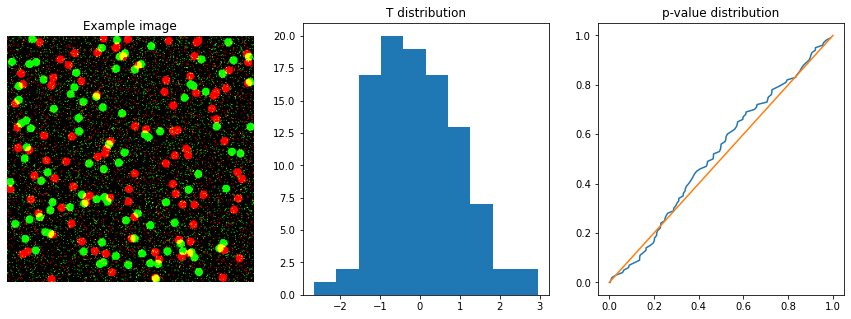

In [1051]:
n = 100 # number of test
m = 200 # number of disks
radius = 5 # disk radius
T = np.zeros((n,1)) # T statsitic
P = np.zeros((n,1)) # p value
for i in range(n):
    im1, im2 = create_overlapping_circles((300,300), m, radius, 0.0)
    msg,P[i],T[i] = GcoPS(im1, im2, 0.05, False)

fig,ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(to_rgb(im1,im2))
ax[0].axis('off')
ax[0].set_title('Example image')
ax[1].hist(T)
ax[1].set_title('T distribution')
ax[2].plot( np.sort(np.ravel(P)), np.arange(P.size)/P.size )
ax[2].plot(np.linspace(0,1), np.linspace(0,1))
ax[2].set_title('p-value distribution')
print(f'T mean: {np.mean(T)}, std: {np.std(T)}')
print(f'Number of time the p-value is < 0.05 : {100 * np.mean(P<0.05)}%')
print(f'Mean of p-value {np.mean(P)}')


Test the procedure for various level of colocalization

Text(0.5, 1.0, 'GcoPS')

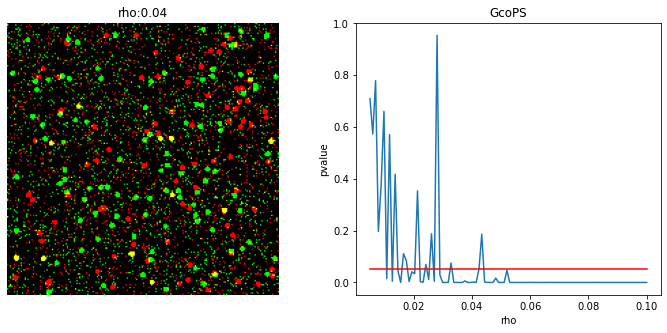

In [813]:
n = 100
m = 200
radius = 2
rho = np.linspace(1/m,0.1,n)
p = np.zeros((n,1))
for i,r in enumerate(rho):
    im1,im2 = create_overlapping_circles((300,300), m, radius, r)
    p[i] = GcoPS(im1, im2, 0.05)[1]

# find the last time that p > 0.05
vec = np.where(p>5e-2)[0]
if vec.size > 0 :
    k =  vec[-1]
else :
    k  = 0
im1, im2 = create_overlapping_circles((200,200), m, radius, rho[k])
fig, ax = plt.subplots(1,2,figsize=(12,5))
ax[0].imshow(to_rgb(im1,im2))
ax[0].set_title(f'rho:{rho[k]:.2f}')
ax[0].axis('off')
ax[1].plot(rho,p)
ax[1].plot(rho, 0.05*np.ones(rho.shape),'r')
ax[1].set_xlabel('rho')
ax[1].set_ylabel('pvalue')
ax[1].set_title('GcoPS')


Manders M1:0.037, M2:0.034
GCoPS D:0.000, T:0.705, pvalue:0.2404 The two sets are independant
Manders M1:0.065, M2:0.064
GCoPS D:0.001, T:3.803, pvalue:7.1447e-05 The two sets are not independant


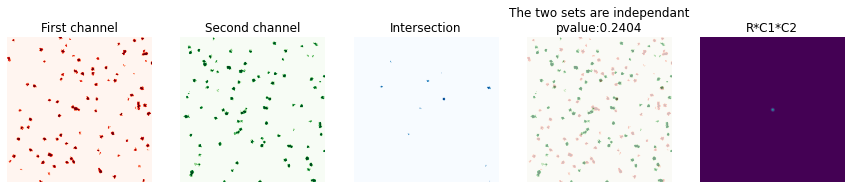

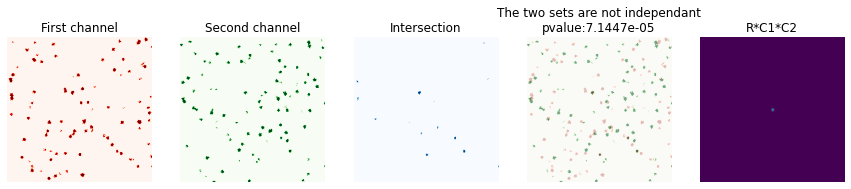

In [1053]:
# Here is a example using the same data than the one on the GCOPS's website for reference 

# non colocalized example
im1a = plt.imread('https://team.inria.fr/serpico/files/2020/08/nonoise_noshift1_rho0.png')
im1b = plt.imread('https://team.inria.fr/serpico/files/2020/08/nonoise_noshift2_rho0.png')
msg1, pvalue1, t1 = GcoPS(im1a, im1b, 0.05, True, True) 

# colocalized example
im2a = plt.imread('https://team.inria.fr/serpico/files/2020/08/nonoise_noshift1_rho05.png')
im2b = plt.imread('https://team.inria.fr/serpico/files/2020/08/nonoise_noshift2_rho05.png')
msg2, pvalue2, t2 = GcoPS(im2a, im2b, 0.05, True, True) 

## Correlation

The correlation can be estimated using the Pearson correlation coefficient PCC


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 511.5, 511.5, -0.5)

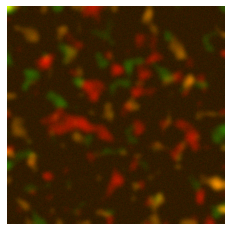

In [498]:
import numpy as np
from skimage import filters

def create_correlated_images(shape:int, radius:float, p:float, noise_level:float):
    '''   Create a pair of correlated images

    Parameters
    ----------
    shape : image size
    radius : standard deviation of the Gaussian blur
    p : Amount of correlation  [0,1]
    noise_level : amount of noise (factor of the std)
    Returns
    -------
    two numpy arrays
    '''
    im = list()
    for i in range(3):
        im.append(np.random.normal(0,10,size=shape))
        im[i] = filters.gaussian(im[i], radius, mode='reflect')
        im[i] = im[i] - np.std(im[i])
        im[i][np.where(im[i]<0)] = 0
        if i > 0 :
            im[i] = p * im[0] + (1-p) * im[i]
            im[i] = filters.gaussian(im[i], radius/3, mode='reflect')
            if noise_level > 0:
                im[i] = im[i] + np.random.normal(0,noise_level*np.std(im[i]),size=shape)
            a,b = np.min(im[i]), np.max(im[i])
            im[i] = 100 + 500 * (im[i] - a) / (b-a)

    return im[1], im[2]

im1,im2 = create_correlated_images((512,512),10,0.5,0.4)
plt.imshow(to_rgb(im1,im2))
plt.axis('off')


An important step in colocalization analysis is to visualize a 2D histogram. It allows to identify clusters and understand the type of correlation between two images.

In [826]:
from skimage import filters

def coloc_histogram(im1, im2, height:int=200, width:int=200):
    '''  2D Colocalization histogram

    Parameter
    ---------
    im1 : first channel (numpy array) 
    im2 : second channel (numpy array) 
    height: int (optional), the height of the buffer
    width:  int (optional), the width of the buffer
    Result
    ------
    ax_extent: the extents of the axis
    buffer : the histogram
    [1] https://stackoverflow.com/questions/42639129/is-matplotlib-scatter-plot-slow-for-large-number-of-data
    '''
    im1 = np.ravel(im1)
    im2 = np.ravel(im2)
    xlims = (im1.min(), im1.max())
    ylims = (im2.min(), im2.max())
    dxl = xlims[1] - xlims[0]
    dyl = ylims[1] - ylims[0]
    buffer = np.zeros((height+1, width+1))
    n = np.prod(im1.shape)
    for i in range(n):
        x0 = int(round(((im1[i]- xlims[0]) / dxl) * width))
        y0 = int(round((1 - (im2[i] - ylims[0]) / dyl) * height))
        buffer[y0, x0] += 1
    ax_extent = list(xlims)+list(ylims)
    return ax_extent, buffer

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, '2D histogram')

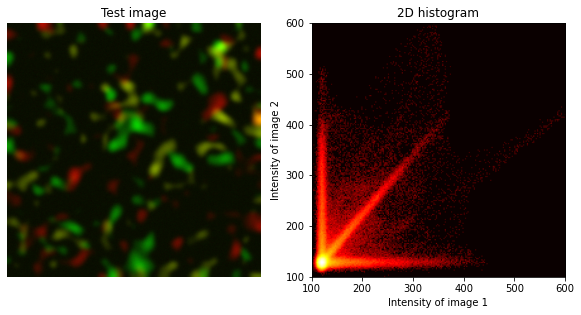

In [1054]:
im1,im2 = create_correlated_images((500,500),10,0.5,0.1)
ax_extent,h = coloc_histogram(im1,im2)
fig, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].imshow(to_rgb(im1,im2))
ax[0].axis('off')
ax[0].set_title('Test image')
ax[1].imshow(np.log(1+h), cmap='hot', extent=ax_extent)
ax[1].set_xlabel('Intensity of image 1')
ax[1].set_ylabel('Intensity of image 2')
ax[1].set_title('2D histogram')

The first method to measure the correlation of two signal is the Pearson correlation coefficient (PCC). The scipy package includes the test as `scipy.stats.pearsonr`. It returns the coefficient and a pvalue.

In [821]:
import scipy 
# compute the pearson correlation coefficient
[r,pvalue] = scipy.stats.pearsonr(im1.ravel(), im2.ravel())
print(f'Pearson correlation:{r:.2f} pvalue {pvalue:0.3g}')

Pearson correlation:0.57 pvalue 0


Sometime a non linear transform can be linking the two images and in that case the Spearman rank coefficient is more appropriate. Again the scipy package conveniently includes the test as `scipy.stats.pearson`.

In [1055]:
[r,pvalue] = scipy.stats.spearmanr(im1.ravel(), im2.ravel())
print(f'Spearman correlation:{r:.2f} pvalue {pvalue:0.3g}')

Spearman correlation:0.30 pvalue 0


The p-values returned by these functions are not very informative and we could instead follows the idea of Costes [1] and suffle the image to see how the value returned by the test varies.

[1] Costes, S., Daelemans, D., Cho, E., Dobbin, Z., Pavlakis, G. and Lockett, S. (2004) Automatic and quantitative measurement of protein‐protein colocalization in live cells. Biophysical Journal, 86, 3993–4003. 

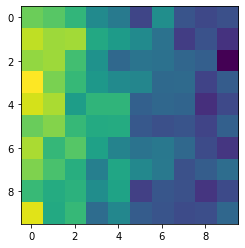

In [1029]:
def extract_blocks(im, block_size):
    N0 = im.shape[0] // block_size
    N1 = im.shape[1] // block_size
    block = np.zeros((N0*N1,block_size,block_size))
    for k0 in range(N0):
        for k1 in range(N1):
            block[k1+N1*k0,:,:] = im[k0*block_size:(k0+1)*block_size,k1*block_size:(k1+1)*block_size]
    return block

im1, im2 = create_correlated_images((200,200),10,rho[i],0.2)
blk = extract_blocks(im1, 10)      
plt.imshow(blk[1,:,:])    

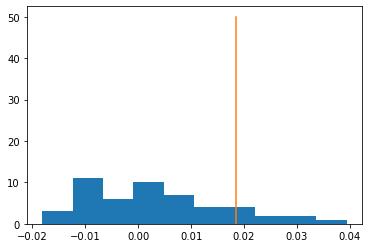

In [1115]:
def shuffle_block_test(im1,im2,test,N,block_size=10):
    ''' Suffle images blocks N times and apply test

    Parameters
    ----------
    im1 : image 1
    im2 : image 2
    test : the test function returning 1 value and taking 2 input images
    N : number of suffle
    block_size : the size of the blocks

    Result
    ------
    pvalue: the p-value 

    Reference
    ---------
    [1] Costes, S., Daelemans, D., Cho, E., Dobbin, Z., Pavlakis, G. and Lockett, S. (2004) Automatic and quantitative measurement of protein‐protein colocalization in live cells. Biophysical Journal, 86, 3993–4003. 
    '''
    # extract blocks from the image
    blk1 = extract_blocks(im1, block_size)
    blk2 = extract_blocks(im2, block_size)
    # Initialize an array to store correlation coefficients
    r = np.zeros((N,1)) 
    # Perform N random permutation (suffle)
    for i in range(N):
        idx1 = np.random.permutation(np.arange(blk1.shape[0]))
        tmp1 = blk1[idx1,:,:]
        idx2 = np.random.permutation(np.arange(blk2.shape[0]))
        tmp2 = blk1[idx2,:,:]
        # compute the coefficient using the test
        r[i] = test(np.ravel(tmp1), np.ravel(tmp2))
    # compute the test for the all image
    r0 = test(np.ravel(im1),np.ravel(im2))
    pvalue = np.sum(r>r0) / N    
    plt.hist(r)
    plt.plot(np.array((r0,r0)), np.array((0,N)))
    return pvalue

im1, im2 = create_correlated_images((200,200),2,0,1)
p = shuffle_block_test(im1, im2, lambda x,y: scipy.stats.pearsonr(x, y)[0], 50)


In [1134]:
def shuffle_shift_test(im1,im2,test,N):
    r = np.zeros((N,1)) 
    # Perform N random permutation (suffle)
    for i in range(N):
        d1 = np.floor( im1.shape * np.random.rand(1,im1.ndim)).astype('i').ravel().tolist()
        tmp1 = np.roll(im1, d1)
        d2 = np.floor( im2.shape * np.random.rand(1,im2.ndim) ).astype('i').ravel().tolist()
        tmp2 = np.roll(im2, d2)
        r[i] = test(np.ravel(tmp1), np.ravel(tmp2))
    r0 = test(np.ravel(im1),np.ravel(im2))
    pvalue = np.sum(r>r0) / N
    #plt.hist(r)
    #plt.plot(np.array((r0,r0)), np.array((0,N)))
    #plt.imshow(to_rgb(tmp1,tmp2))
    return pvalue

im1, im2 = create_correlated_images((200,200),5,1,0.1)
p = shuffle_shift_test(im1, im2, lambda x,y: scipy.stats.pearsonr(x,y)[0], 100)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


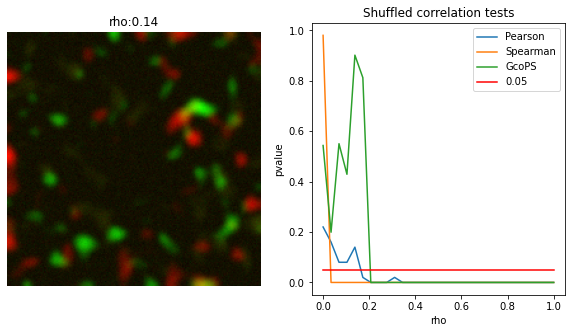

In [1137]:
n = 30
rho = np.linspace(0,1,n)
p = np.zeros((n,1))
s = np.zeros((n,1))
g = np.zeros((n,1))
for i,r in enumerate(rho):
    im1, im2 = create_correlated_images((300,300),2,rho[i],0.)
    p[i] = shuffle_shift_test(im1, im2, lambda x,y: scipy.stats.pearsonr(x,y)[0], 50)
    s[i] = shuffle_shift_test(im1, im2, lambda x,y: scipy.stats.spearmanr(x,y)[0], 50)
    g[i] = GcoPS(im1>150,im2>150,0.05,False,False)[1]

# find the last time that p > 0.05
vec = np.where(p>5e-2)[0]
if vec.size > 0 :
    k =  vec[-1]
else :
    k  = 0
im1,im2 = create_correlated_images((200,200),5,rho[k],0.2)
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(to_rgb(im1,im2))
ax[0].set_title(f'rho:{rho[k]:.2f}')
ax[0].axis('off')
l1, = ax[1].plot(rho,p)
l2, = ax[1].plot(rho,s)
l3, = ax[1].plot(rho,g)
l4, = ax[1].plot(rho, 0.05*np.ones(rho.shape),'r')
ax[1].set_xlabel('rho')
ax[1].set_ylabel('pvalue')
ax[1].set_title('Shuffled correlation tests')
ax[1].legend([l1,l2,l3,l4],['Pearson','Spearman','GcoPS','0.05'])


## Point cloud colocalization

We can use the Ripley cross K function to evaluate the colocalization of two point pattern. 

(2, 200) (2, 200)


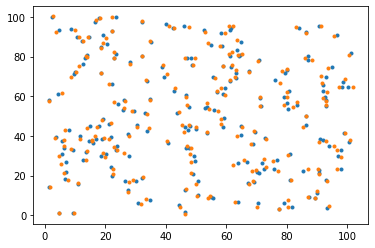

In [1258]:
def generate_colocalized_points(shape,n,rho,noise_level):
    p = np.matmul(np.diag(np.array(shape)), np.random.rand(2,n))
    v = np.random.rand(1, n)
    p1 = p[:,v.ravel()<0.5+rho/2]
    p2 = p[:,v.ravel()>0.5-rho/2]
    p1 = p1 + noise_level * np.random.random_sample(p1.shape)
    p2 = p2 + noise_level * np.random.random_sample(p2.shape)
    return p1, p2

p1,p2 = generate_colocalized_points((100,100),200,1,2)
print(p1.shape,p2.shape)
plt.plot(p1[0,:],p1[1,:],'.')
plt.plot(p2[0,:],p2[1,:]+.01,'.')


Text(0.5, 1.0, 'Cross Pair correlation function')

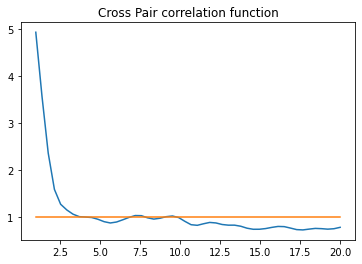

In [1262]:
import math

def cross_paircorrelation(p1,p2,radius,bandwidth):
    ''' Compute the cross paircorrelation function between set p1 and p2

    Parameter
    ---------
    p1 : ndarray coordinates of first points cloud
    p2 : ndarray coordinates of first points cloud
    radius : radius for which to compute the paricorrelation
    bandwidth : smoothing bandwidth
    Result
    ------
    pcf : pair correlation function
    Note
    ----
    There is no boundary correction
    '''
    pcf = np.zeros(radius.shape)
    a = 1/math.sqrt(2*math.pi*bandwidth*bandwidth)
    for i in range(p1.shape[1]):
        for j in range(p2.shape[1]):
            d = math.sqrt(np.sum((p1[:,i] - p2[:,j])**2))
            for k in range(radius.size):
                pcf[k] +=  a * math.exp(-0.5*((radius[k] - d) / bandwidth)**2)
    A = (np.max(p1[0,:]) -  np.min(p1[0,:])) * (np.max(p1[1,:]) -  np.min(p1[1,:]))
    c =  ( A / ( 2 * math.pi * radius * p1.shape[1] * p2.shape[1]) )
    pcf = c * pcf
    return pcf

radius = np.linspace(1,20,50)
pcf = cross_paircorrelation(p1,p2,radius,0.5)
plt.plot(radius,pcf)
plt.plot(radius,np.ones((radius.size,1)))
plt.title('Cross Pair correlation function')